In [60]:
#Librerias
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
import random, math
from scipy.optimize import minimize
from numpy.random import rand
%matplotlib inline 
import numpy as np
plt.rcParams['figure.figsize'] = 14, 7 #ancho, alto

font = {'weight' : 'bold',
        'size'   : 15}
random.seed(1) # semilla inicial

In [61]:
import numpy as np
import random

def vecinosp(i, j, Momentos, n):
    V = []
    if i > 0:
        V.append(Momentos[i-1][j])
    if i < n-1:
        V.append(Momentos[i+1][j])
    if j > 0:
        V.append(Momentos[i][j-1])
    if j < n-1:
        V.append(Momentos[i][j+1])
    return V

def Ein(mu, V, Jm, H):
    sum = 0
    if Jm != 0:
        for v in V:
            sum += np.dot(mu, v)
    return (-Jm * sum - np.dot(mu, H))

def Info(h, T, Jm, J, Momentos, n):
    H = np.array([0, 0, float(h)])
    k_B = 1
    Etot = 0
    Mtot = 0
    
    for i in range(n):
        for j in range(n):
            V = vecinosp(i, j, Momentos, n)
            Etot += Ein(Momentos[i][j], V, Jm, H)
            Mtot += Momentos[i][j][2]
    
    EE = []
    MM = []
    iter = 200
    Theta = np.linspace(-np.pi, np.pi, int(2*J+1)).tolist()
    Phi = np.linspace(0, 2*np.pi, 100)
    
    for r in range(iter):
        for i in range(n):
            for j in range(n):
                mu = Momentos[i][j]
                V = vecinosp(i, j, Momentos, n)
                
                random.seed()
                phi = np.random.choice(Phi)
                theta = np.random.choice(Theta)
                mutrial = np.array([np.sin(theta) * np.cos(phi), np.sin(theta) * np.sin(phi), np.cos(theta)])
                
                E_1 = Ein(mu, V, Jm, H)
                E_2 = Ein(mutrial, V, Jm, H)
                deltaE = E_2 - E_1
                deltaM = mutrial[2] - mu[2]
                
                if deltaE <= 0:
                    Momentos[i][j] = mutrial
                    Etot += deltaE
                    Mtot += deltaM
                else:
                    rand = np.random.random()
                    W = np.exp(-(E_2 - E_1) / (k_B * T))
                    if rand <= W:
                        Momentos[i][j] = mutrial
                        Etot += deltaE
                        Mtot += deltaM
        
        EE.append(float(Etot))
        MM.append(float(Mtot))
    
    return np.arange(iter), EE, MM, np.mean(Momentos[:, :, 2]), Momentos


In [62]:
# Definir parámetros de la simulación
h = 0.5
T = 1.0
Jm = 1.0
J = 1.5
n = 10

# Generar configuración inicial de momentos magnéticos
Momentos = np.random.rand(n, n, 3)
Momentos[:, :, 2] = np.where(Momentos[:, :, 2] < 0.5, -1, 1)

# Ejecutar simulación
iteraciones, energia, magnetizacion, magnetizacion_promedio, nuevos_momentos = Info(h, T, Jm, J, Momentos, n)


In [63]:
def B(H,t,J): #función de Brillouin para ajustar
    BJ=[]
    for h in H:
        eta=h/t
        BJ.append((1/J)*((J+1/2)*(np.tanh(eta*(J+1/2)))**(-1)-(1/2)*(np.tanh(eta/2))**(-1)) )
        
    return BJ

In [64]:
#Valores 
J=3/2
Jm=0
T3=[70]
T2=[40]
T1=[10]
h=np.arange(-100,110,5)
hh=np.linspace(-100,100,1000)
hp=np.arange(100,-110,-10)

for t in T1:
    Mo1=[]
    for s in tqdm(h):
        F1=Info(s,t,Jm,J, Momentos,n)
        Mo1.append(float(F1[3]))  
        Momentos=F1[4] 
for t in T2:
    Mo2=[]
    for s in tqdm(h):
        F2=Info(s,t,Jm,J, Momentos,n)
        Mo2.append(float(F2[3]))  
        Momentos=F2[4]

for t in T3:
    Mo3=[]
    for s in tqdm(h):
        F3=Info(s,t,Jm,J, Momentos,n)
        Mo3.append(float(F3[3]))  
        Momentos=F3[4]
    

100%|██████████| 42/42 [01:24<00:00,  2.01s/it]


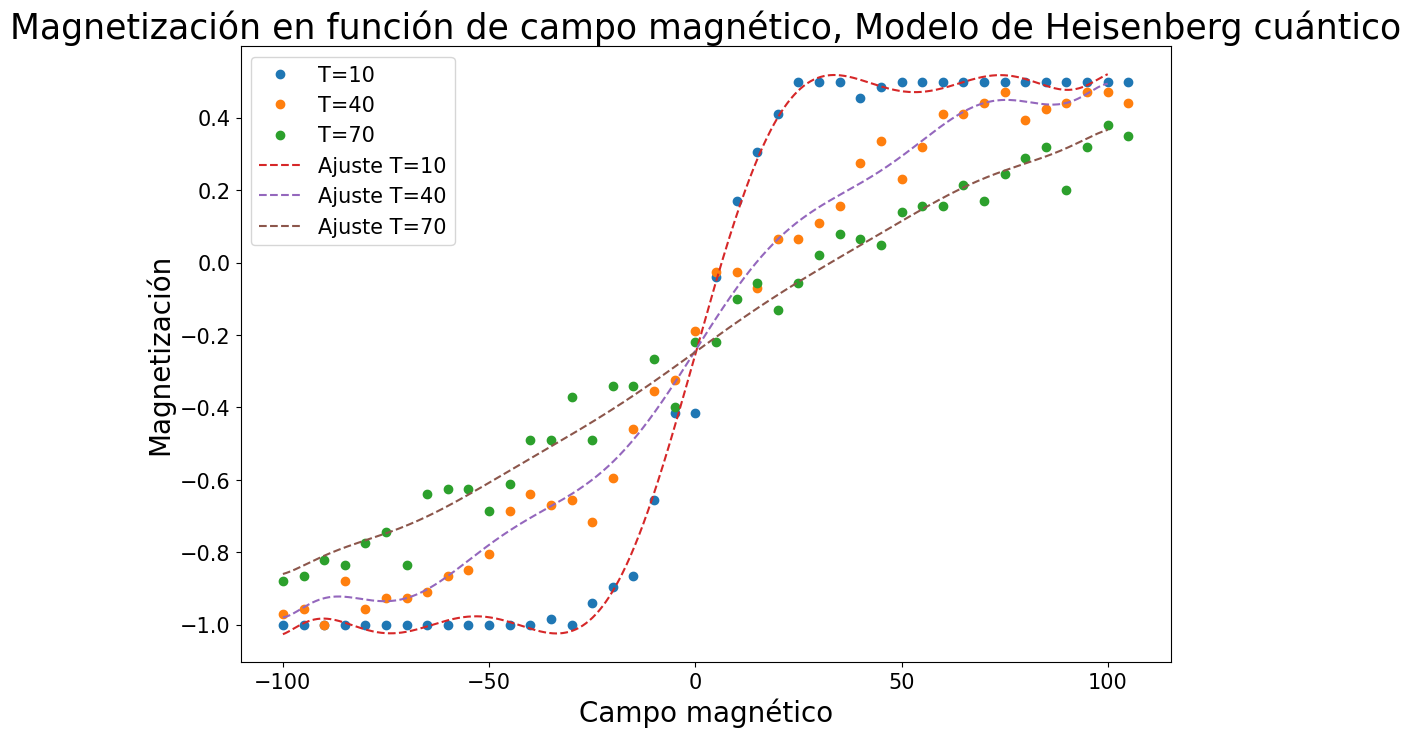

In [66]:
#Gráfica de magnetización en función de campo magnético y ajuste para diferentes temperaturas en subplots
#Ajustemos la función de Brillouin a los datos y sciPy nos da los parámetros de ajuste
def B(H,T,a): #función de Brillouin para ajustar
    return a*(np.tanh((H/T)))**(-1) -  (np.tanh((H/T)))**(-1)

#Escribamos B con la tangente hiperbólica como un polinomio de grado 7 de (H/T

def B(H,T,a,b,c,d,e,f,g): #función de Brillouin para ajustar con polinomio de grado 12 de (H/T)

    return a*(H/T)**11 + b*(H/T)**9 + c*(H/T)**7 + d*(H/T)**5 + e*(H/T)**3 + f*(H/T) + g

#Ajustemos la función de Brillouin a los datos y sciPy nos da los parámetros de ajuste
from scipy.optimize import curve_fit
popt1, pcov1 = curve_fit(B, h, Mo1)
popt2, pcov2 = curve_fit(B, h, Mo2)
popt3, pcov3 = curve_fit(B, h, Mo3)
    
#Grafiquemos los datos y el ajuste
plt.figure(figsize=(12,8))
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.title('Magnetización en función de campo magnético, Modelo de Heisenberg cuántico',fontsize=25)
plt.plot(h,Mo1,'o',label='T={}'.format(T1[0]))
plt.plot(h,Mo2,'o',label='T={}'.format(T2[0]))
plt.plot(h,Mo3,'o',label='T={}'.format(T3[0]))
plt.plot(hh,B(hh,*popt1),'--',label='Ajuste T={}'.format(T1[0]))
plt.plot(hh,B(hh,*popt2),'--',label='Ajuste T={}'.format(T2[0]))
plt.plot(hh,B(hh,*popt3),'--',label='Ajuste T={}'.format(T3[0]))
plt.xlabel('Campo magnético',fontsize= 20)
plt.ylabel('Magnetización',fontsize= 20)
plt.legend(fontsize= 15)
plt.show()



In [67]:
#Ahora Heisenberg clasico

def Info(h, T, Jm, J, Momentos, n):
    H = np.array([0, 0, float(h)])
    k_B = 1
    Etot = 0
    Mtot = 0
    
    for i in range(n):
        for j in range(n):
            V = vecinosp(i, j, Momentos, n)
            Etot += Ein(Momentos[i][j], V, Jm, H)
            Mtot += Momentos[i][j][2]
    
    EE = []
    MM = []
    iter = 200
    Theta = np.linspace(-np.pi, np.pi, 1000).tolist()
    Phi = np.linspace(0, 2*np.pi, 100)
    
    for r in range(iter):
        for i in range(n):
            for j in range(n):
                mu = Momentos[i][j]
                V = vecinosp(i, j, Momentos, n)
                
                random.seed()
                phi = np.random.choice(Phi)
                theta = np.random.choice(Theta)
                mutrial = np.array([np.sin(theta) * np.cos(phi), np.sin(theta) * np.sin(phi), np.cos(theta)])
                
                E_1 = Ein(mu, V, Jm, H)
                E_2 = Ein(mutrial, V, Jm, H)
                deltaE = E_2 - E_1
                deltaM = mutrial[2] - mu[2]
                
                if deltaE <= 0:
                    Momentos[i][j] = mutrial
                    Etot += deltaE
                    Mtot += deltaM
                else:
                    rand = np.random.random()
                    W = np.exp(-(E_2 - E_1) / (k_B * T))
                    if rand <= W:
                        Momentos[i][j] = mutrial
                        Etot += deltaE
                        Mtot += deltaM
        
        EE.append(float(Etot))
        MM.append(float(Mtot))
    
    return np.arange(iter), EE, MM, np.mean(Momentos[:, :, 2]), Momentos


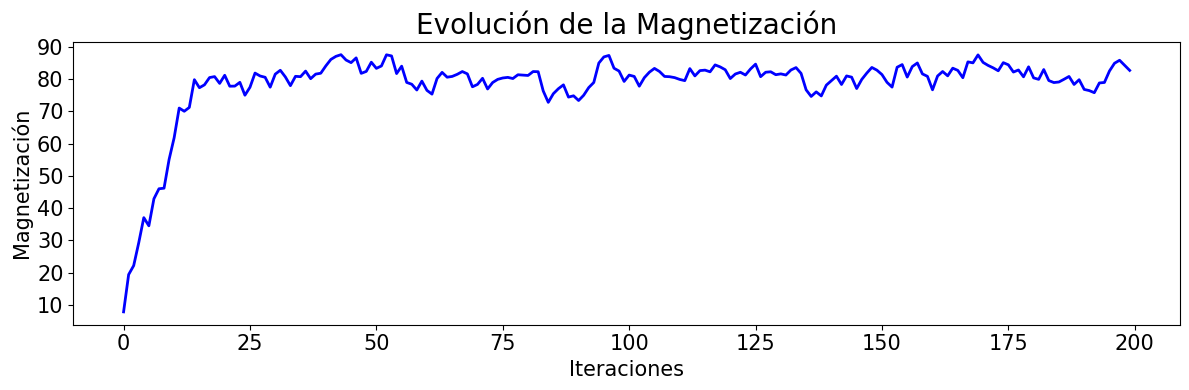

In [70]:
import matplotlib.pyplot as plt

# Definir parámetros de la simulación
h = 0.5
T = 1.0
Jm = 1.0
J = 1.5
n = 10

# Generar configuración inicial de momentos magnéticos
Momentos = np.random.rand(n, n, 3)
Momentos[:, :, 2] = np.where(Momentos[:, :, 2] < 0.5, -1, 1)

# Ejecutar simulación
iteraciones, energia, magnetizacion, magnetizacion_promedio, nuevos_momentos = Info(h, T, Jm, J, Momentos, n)

# Graficar resultados
plt.figure(figsize=(12, 4))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.plot(iteraciones, magnetizacion, linewidth=2, color='blue')
plt.xlabel('Iteraciones', fontsize=15)
plt.ylabel('Magnetización', fontsize=15)
plt.title('Evolución de la Magnetización', fontsize=20)

plt.tight_layout()
plt.show()



In [71]:
h=np.arange(-100,110,5)
T1=[2]
for t in T1:
    Mo11=[]
    for s in tqdm(h):
        F11=Info(s,t,Jm,J, Momentos,n)
        Mo11.append(float(F11[3]))  
        Momentos=F11[4] 

T2=[10]
for t in T2:
    Mo12=[]
    for s in tqdm(h):
        F12=Info(s,t,Jm,J, Momentos,n)
        Mo12.append(float(F12[3]))  
        Momentos=F12[4] 

T3=[50]
for t in T3:
    Mo13=[]
    for s in tqdm(h):
        F13=Info(s,t,Jm,J, Momentos,n)
        Mo13.append(float(F13[3]))  
        Momentos=F13[4] 



100%|██████████| 42/42 [03:10<00:00,  4.55s/it]


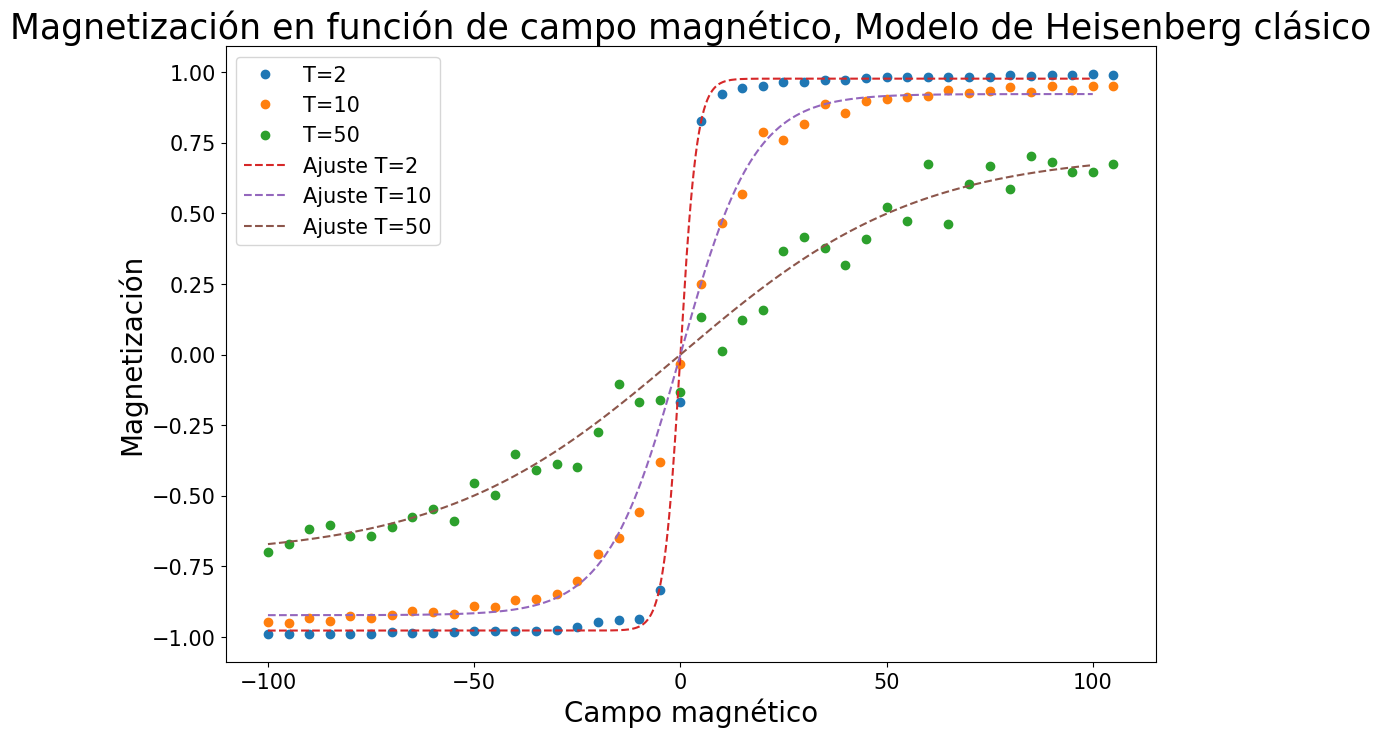

In [72]:
#GRáfica de magnetización en función de campo magnético y ajuste para diferentes temperaturas en subplots
def L(H,T,a): #función de Langevin para ajustar
    return a*np.tanh((H/T)) 

#Ajustemos la función de Langevin a los datos y sciPy nos da los parámetros de ajuste
from scipy.optimize import curve_fit
popt11, pcov11 = curve_fit(L, h, Mo11)
popt12, pcov12 = curve_fit(L, h, Mo12)
popt13, pcov13 = curve_fit(L, h, Mo13)

#Grafiquemos los datos y el ajuste

plt.figure(figsize=(12,8))
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.title('Magnetización en función de campo magnético, Modelo de Heisenberg clásico',fontsize=25)
plt.plot(h,Mo11,'o',label='T={}'.format(T1[0]))

plt.plot(h,Mo12,'o',label='T={}'.format(T2[0]))
plt.plot(h,Mo13,'o',label='T={}'.format(T3[0]))
plt.plot(hh,L(hh,*popt11),'--',label='Ajuste T={}'.format(T1[0]))
plt.plot(hh,L(hh,*popt12),'--',label='Ajuste T={}'.format(T2[0]))

plt.plot(hh,L(hh,*popt13),'--',label='Ajuste T={}'.format(T3[0]))
plt.xlabel('Campo magnético',fontsize= 20)
plt.ylabel('Magnetización',fontsize= 20)
plt.legend(fontsize= 15)

plt.show()
